<a href="https://colab.research.google.com/github/HoagnDawg35/CNN-CAM-implementation/blob/main/CNN_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 CNN + CAM Implementation Notebook


---


In this notebook, I build a basic framework for a Convolutional Neural Network (CNN) model for image classification. I also implement Class Activation Mapping (Grad-CAM) to visualize which areas of the image the CNN focuses on most for each predicted class.

🧪 This is a great tool to better understand and interpret CNN decisions, you could Run all sessions for code clear visual. The model is trained on the **T4 GPU** config.
Have fun exploring!


---


*This notebook belongs to [**Huy-Hoang Dang**](https://www.facebook.com/Hoang.huy012) at the [**UTE AI Laboratory**](https://ute-ai-lab.github.io/UTE-AI-LAB.io/).*

## I. Install and Import Dependencies

⚠️ [**Important note! Must checkout!**](https://www.youtube.com/watch?v=dQw4w9WgXcQ&list=RDdQw4w9WgXcQ&start_radio=1) ⚠️

In [ ]:
!pip install tf-keras-vis

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, datasets, models, regularizers
import matplotlib.pyplot as plt
import numpy as np

## II. Dataset
Load and plot the CIFAR10 dataset in which I used for model's training and testing.

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize giá trị của ảnh về 0 và 1
train_images, test_images = train_images / 255.0, test_images / 255.0

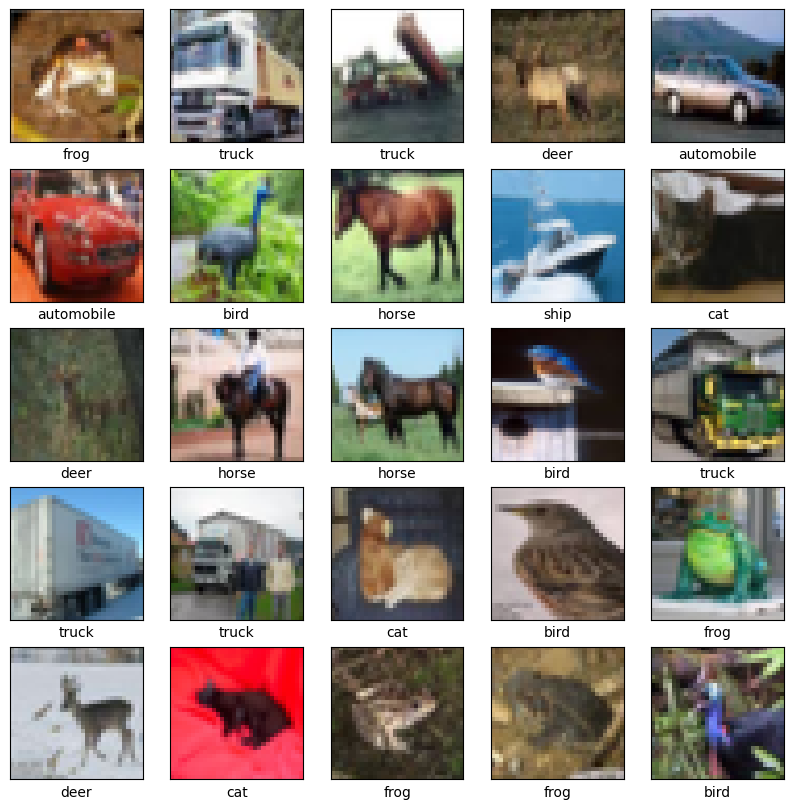

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

## III. Build the Model

In this notebook, I had config 3 2D-Convolution layers that have ReLU activation. <br> *Check out the model's summary for more information!*

In [ ]:
# Khởi tạo model
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3), kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001), name='last_conv'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.GlobalMaxPooling2D())

# Fully connected
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(10, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Check out the model's configuration

In [ ]:
model.summary()

# #Double check tên layer conv
# for layer in model.layers:
#     print(f"{layer.name} ({type(layer).__name__})")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_conv (Conv2D)              │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,672 (721.38 KB)

 Trainable params: 61,450 (240.04 KB)

 Non-trainable params: 320 (1.25 KB)

 Optimizer params: 122,902 (480.09 KB)

## V. Training model

For the Training process, I'm using the early_stop mechanism, which stop my training process when the Validating value does not change through 5 Epoches.

In [ ]:
#Setup dừng sớm để tránh overfitting
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=50,
                    validation_data=(test_images, test_labels),
                    callbacks=[early_stop])

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.2861 - loss: 2.1095 - val_accuracy: 0.3791 - val_loss: 1.7677
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.4692 - loss: 1.5757 - val_accuracy: 0.4950 - val_loss: 1.6475
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5420 - loss: 1.4126 - val_accuracy: 0.5139 - val_loss: 1.5675
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5780 - loss: 1.3401 - val_accuracy: 0.5498 - val_loss: 1.3594
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6059 - loss: 1.2756 - val_accuracy: 0.5771 - val_loss: 1.3562
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6237 - loss: 1.2481 - val_accuracy: 0.6202 - val_loss: 1.2051
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6400 - loss: 1.2047 - val_accuracy: 0.6339 - val_loss: 1.2190
Epoch 8/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6477 - loss: 1.1892 - val_accu

I plot out the model's accuracy and loss to understand my model's state (Good, Overfitting, Underfitting, etc.)

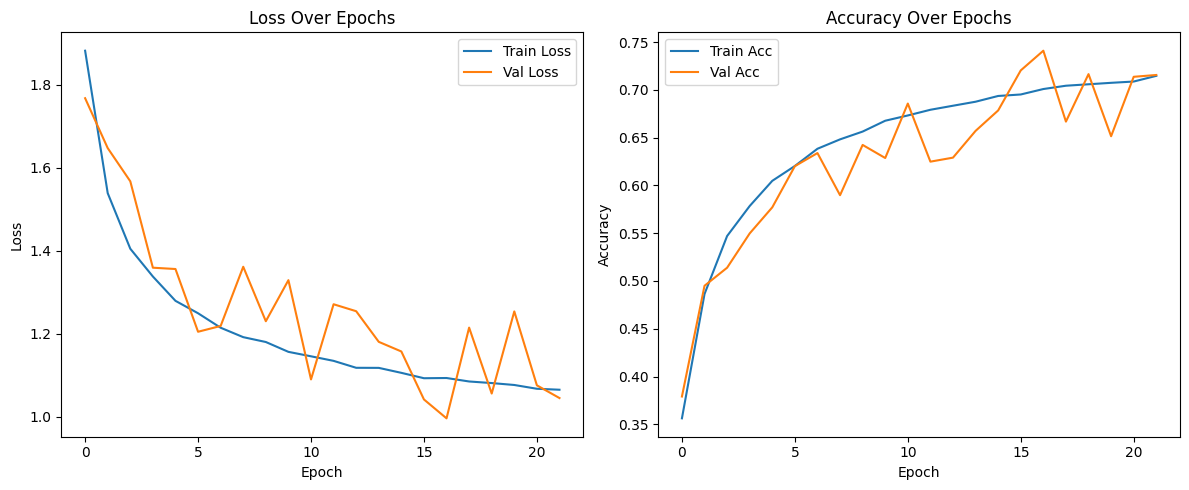

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

I also get the Gradient Flow through the layers of the model.

kernel                                    Gradient norm: 4.200973
bias                                      Gradient norm: 0.000001
gamma                                     Gradient norm: 0.445381
beta                                      Gradient norm: 0.262777
kernel                                    Gradient norm: 2.750189
bias                                      Gradient norm: 0.000000
gamma                                     Gradient norm: 0.385598
beta                                      Gradient norm: 0.272191
kernel                                    Gradient norm: 2.950457
bias                                      Gradient norm: 0.000000
gamma                                     Gradient norm: 0.730772
beta                                      Gradient norm: 0.327611
kernel                                    Gradient norm: 3.203109
bias                                      Gradient norm: 0.202787
kernel                                    Gradient norm: 0.671745
bias      

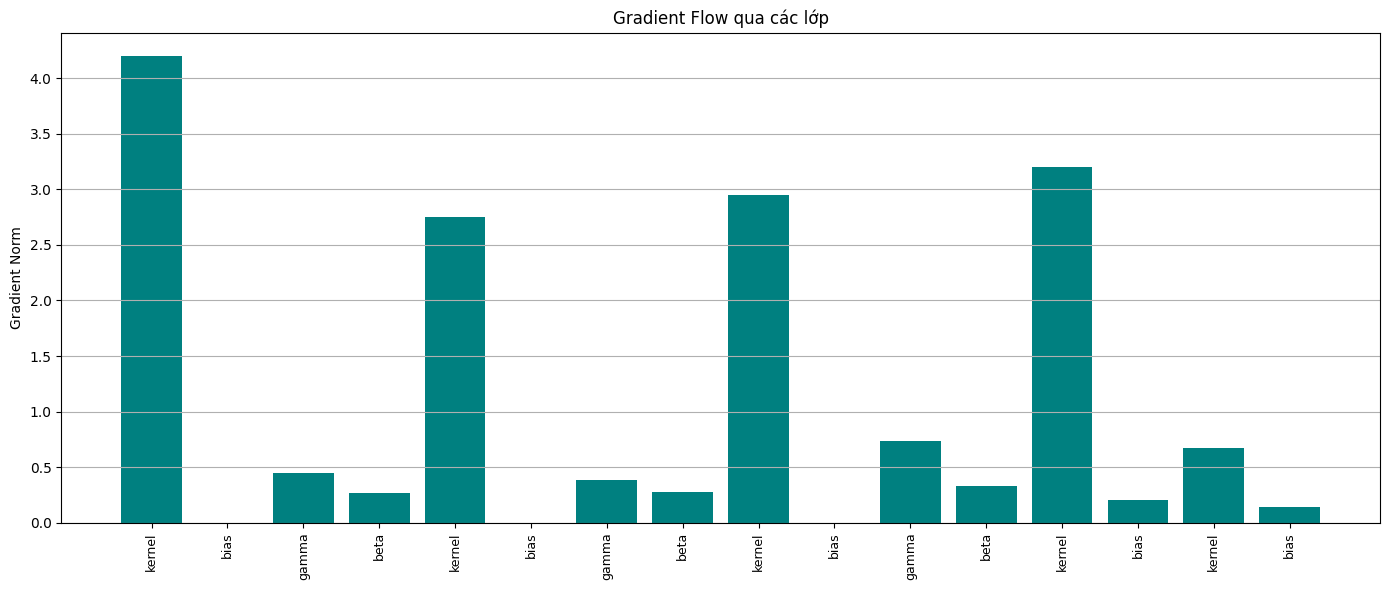

In [ ]:
import tensorflow as tf
import numpy as np

# Lấy một batch dữ liệu mẫu
x_batch = train_images[:32]  # hoặc x_train nếu bạn dùng tên khác
y_batch = train_labels[:32]

# Mở gradient tape
with tf.GradientTape() as tape:
    # Tính toán forward pass
    logits = model(x_batch, training=True)

    # Dùng loss phù hợp
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    loss = loss_fn(y_batch, logits)

# Tính gradient theo tất cả trainable weights
grads = tape.gradient(loss, model.trainable_weights)

# In thông tin về độ lớn gradient
for weight, grad in zip(model.trainable_weights, grads):
    if grad is not None:
        grad_norm = tf.norm(grad).numpy()
        print(f"{weight.name:<40}  Gradient norm: {grad_norm:.6f}")
    else:
        print(f"{weight.name:<40}  Gradient is None")

import matplotlib.pyplot as plt

# Lưu lại tên layer và norm
layer_names = []
gradient_norms = []

for weight, grad in zip(model.trainable_weights, grads):
    if grad is not None:
        grad_norm = tf.norm(grad).numpy()
        layer_names.append(weight.name)
        gradient_norms.append(grad_norm)

# Vẽ biểu đồ
plt.figure(figsize=(14, 6))
plt.bar(range(len(gradient_norms)), gradient_norms, color='teal')
plt.xticks(range(len(layer_names)), layer_names, rotation=90, fontsize=9)
plt.ylabel('Gradient Norm')
plt.title('Gradient Flow qua các lớp')
plt.tight_layout()
plt.grid(True, axis='y')
plt.show()


## VI. Class Activation Mapping Implementation
Class Activation Mapping (CAM) will allow me to determind on which area will my model focus mostly for each class of the datasets.

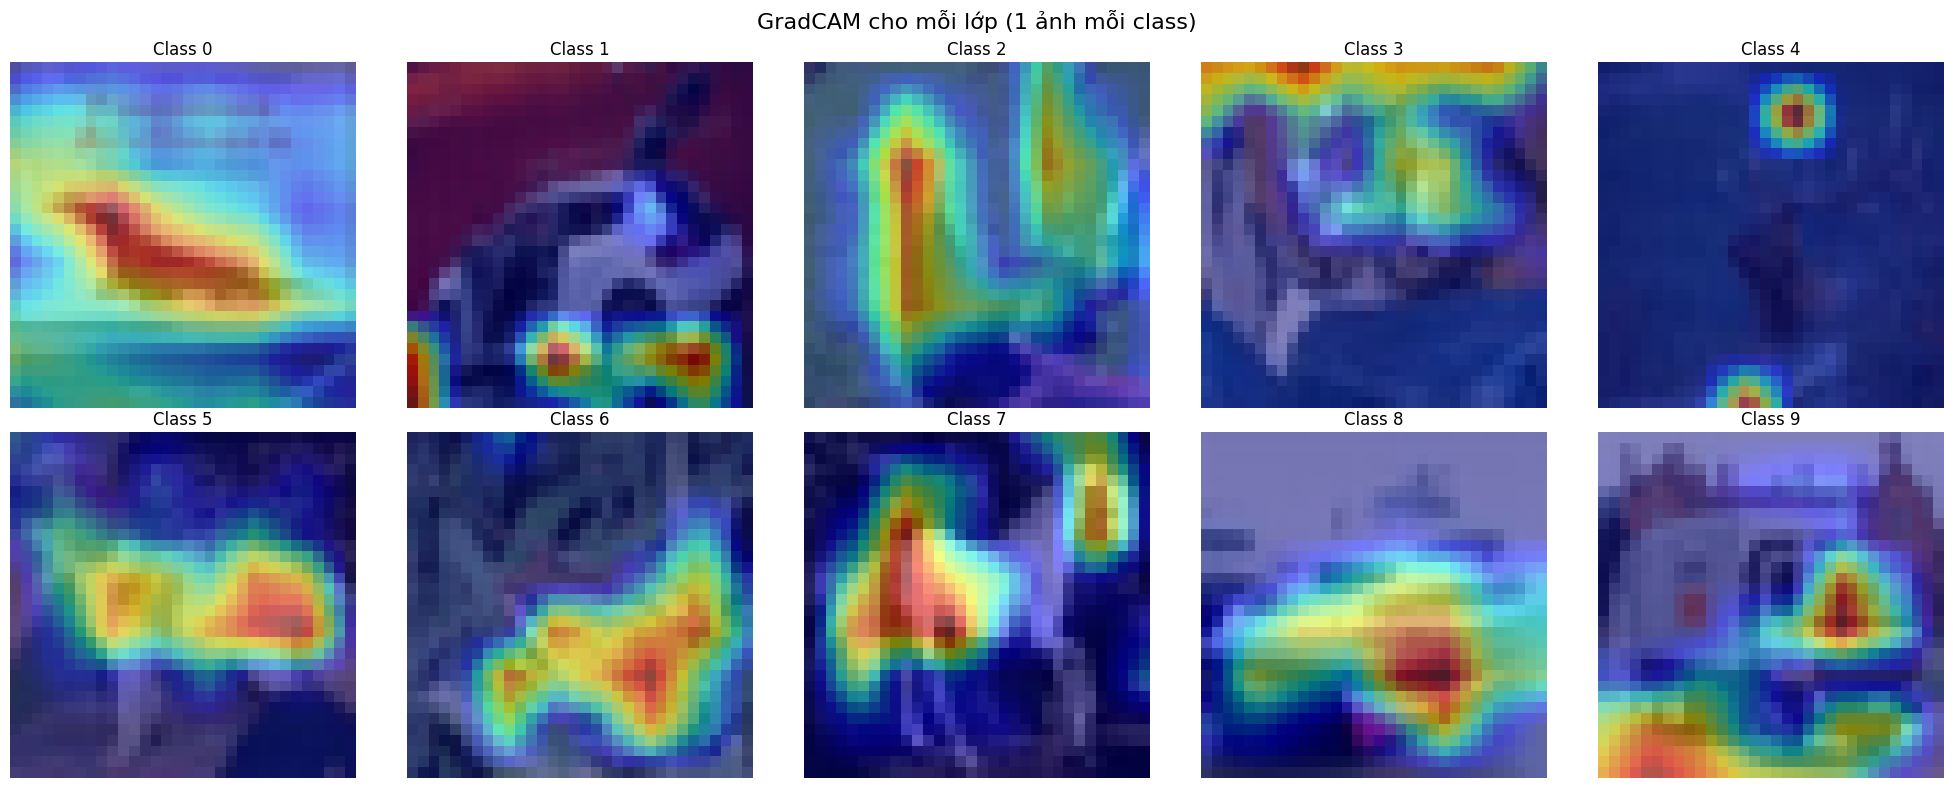

In [ ]:
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.scores import CategoricalScore
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def custom_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear

# In this notebook, I will use the GradCAM for CAM visualization.
gradcam = Gradcam(model, model_modifier=custom_modifier, clone=True)

# GradCAM cho mỗi class.
num_classes = 10
images_per_class = []

# Chọn 1 ảnh cho mỗi class.
for class_idx in range(num_classes):
    for i in range(len(test_labels)):
        if test_labels[i][0] == class_idx:
            images_per_class.append((test_images[i], class_idx))
            break

# Hiển thị heatmaps.
plt.figure(figsize=(20, 8))

for idx, (img, label) in enumerate(images_per_class):
    input_img = np.expand_dims(img, axis=0)
    score = CategoricalScore([label])
    cam = gradcam(score, input_img, penultimate_layer='last_conv')
    heatmap = np.uint8(255 * cam[0])

    # Vẽ ảnh + heatmap.
    plt.subplot(2, 5, idx + 1)
    plt.imshow(img)
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.title(f'Class {label}')
    plt.axis('off')

plt.suptitle('GradCAM cho mỗi lớp (1 ảnh mỗi class)', fontsize=16)
plt.tight_layout()
plt.show()

## Resized CIFAR10 dataset

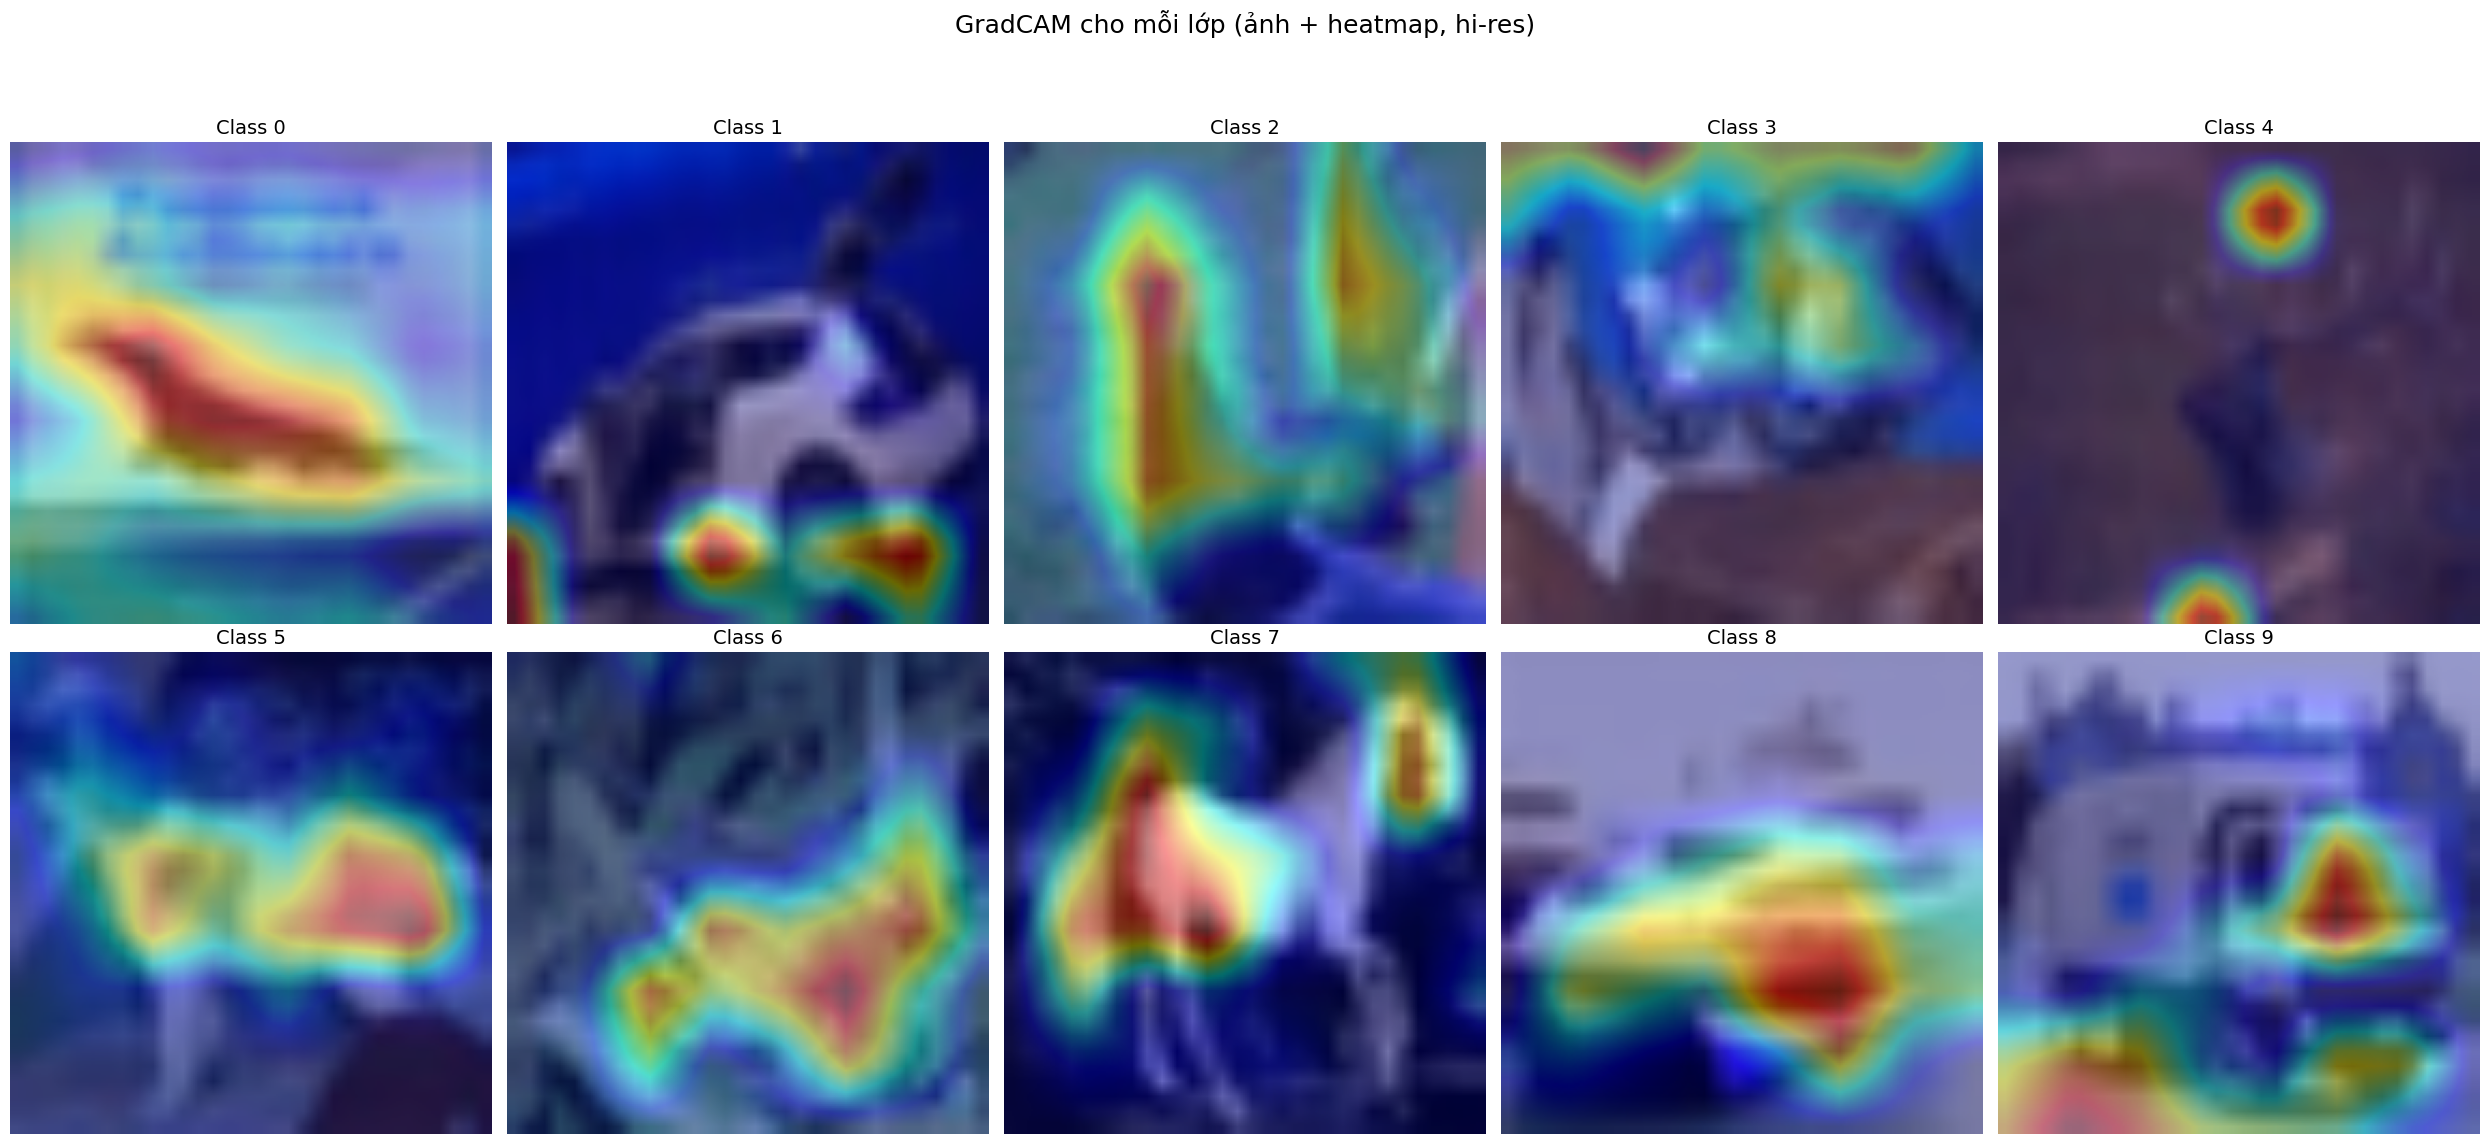

In [ ]:
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.scores import CategoricalScore
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import cv2  # Dùng để overlay heatmap

# --- Custom modifier ---
def custom_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear

# GradCAM setup
gradcam = Gradcam(model, model_modifier=custom_modifier, clone=True)

# --- GradCAM cho mỗi lớp ---
num_classes = 10
images_per_class = []

# Chọn 1 ảnh cho mỗi lớp
for class_idx in range(num_classes):
    for i in range(len(test_labels)):
        if test_labels[i][0] == class_idx:
            images_per_class.append((test_images[i], class_idx))
            break

# Resize lớn hơn
TARGET_SIZE = (224, 224)

# Tăng kích thước hình tổng thể
plt.figure(figsize=(25, 12))

for idx, (img, label) in enumerate(images_per_class):
    input_img = np.expand_dims(img, axis=0)
    score = CategoricalScore([label])
    cam = gradcam(score, input_img, penultimate_layer='last_conv')
    heatmap = cam[0]

    # Resize ảnh gốc và heatmap
    resized_img = tf.image.resize(img, TARGET_SIZE).numpy()
    resized_img = np.clip(resized_img * 255, 0, 255).astype(np.uint8)

    resized_heatmap = tf.image.resize(tf.expand_dims(heatmap, axis=-1), TARGET_SIZE).numpy().squeeze()
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * resized_heatmap), cv2.COLORMAP_JET)

    # Overlay ảnh gốc và heatmap
    overlay = cv2.addWeighted(resized_img, 0.6, heatmap_colored, 0.4, 0)
    overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    # Vẽ ảnh
    plt.subplot(2, 5, idx + 1)
    plt.imshow(overlay_rgb)
    plt.title(f'Class {label}', fontsize=14)
    plt.axis('off')

plt.suptitle('GradCAM cho mỗi lớp (ảnh + heatmap, hi-res)', fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

# Guess someone just get rick-rolled 😀